# EC2 Spot diversification and price history

* **Author:** Carlos Manzanedo Rueda <ruecarlo@amazon.com>
* **License:** This notebook is released under [Apache v2.0 License](https://www.apache.org/licenses/LICENSE-2.0.txt)


This jupyter notebook uses pandas and matplotlib to plot EC2 Spot historic price changes for comparison across different regions, family and instance sizes. 

The code is intended as an example of how to explore EC2 Spot historic prices. Perhaps it's obvious, but please note that historic EC2 price does not define future spot market behaviours!

When constructing a strong and EC2 Fleet, Spot Fleet or Auto Scaling Groups two of the main best practices are: (a) flexibility and (b) diversification. This jupyter notebook allows to visualise changes in the EC2 Spot historic price across regions and instance types. History goes back 3 months (EC2 Spot history API limit). This notebook intends to convey an intuition of why implementing diversification is so important with EC2 Spot as well as helping to compare different instance types and families across regions.

In [ ]:
!pip install --upgrade pandas tqdm boto3 pandas matplotlib

In [1]:
%matplotlib inline
import boto3
import requests
import datetime
from dateutil.tz import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm.notebook import tnrange
from IPython.core.display import display, HTML
import ipywidgets as widgets
display(HTML("<style>.container { width:100% !important; }</style>"))

## Current version of pandas and matplotlib throw a few warnings
## Next version of pandas should remove those
import warnings
warnings.filterwarnings('ignore')

# uncomment the profile_name should you use STS and profiles
# You can read more about profiles and STS here 
# https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-role.html
profile_name = "default"

In [2]:
%%javascript
//Some outputs may create large results. This disables the scrolling within jupyter for those. 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##  Fetching Regions and Instance types

The following section queries the regions and then queries which instance types are available in each region. This may take a few seconds up to a minute.

In [3]:
def getEC2RegionNames(profile_name=profile_name):
    session = boto3.session.Session(profile_name=profile_name)
    ec2_client = session.client('ec2')
    # exception handling
    regions_response = ec2_client.describe_regions()
    return [ region['RegionName'] for region in regions_response['Regions']]

def getInstanceTypesInRegion(profile_name=profile_name, region='us-east-1'):
    session = boto3.session.Session(profile_name=profile_name, region_name=region)
    ec2_client = session.client('ec2')
    instance_types_offering = ec2_client.describe_instance_type_offerings(LocationType='region')
    return [it['InstanceType'] for it in instance_types_offering['InstanceTypeOfferings']]
    
def getGlobalInstanceTypes(profile_name=profile_name):
    regions = getEC2RegionNames()
    instance_type_set = set([])
    for region in tqdm_notebook(regions):
        instances_types = getInstanceTypesInRegion(profile_name=profile_name, region=region)
        for instance_type in instances_types:
            instance_type_set.add(instance_type)
    return instance_type_set

regions_to_compare = sorted(getEC2RegionNames(profile_name=profile_name))
instances_to_complare = sorted(list(getGlobalInstanceTypes(profile_name=profile_name)))

# Add the regions and instances you are interested to explore
regions_w = widgets.SelectMultiple(
    options=regions_to_compare,
    value=regions_to_compare,
    description='Region:'
)
instances_w = widgets.SelectMultiple(
    options=instances_to_complare,
    value=instances_to_complare,
    description='Instance:',
    style={'height': str(30*len(instances_to_complare))}
)
days_back_w = widgets.IntSlider(
    value=30,min=1,max=90,step=1,
    description='Days back:',
)
cap_price_w = widgets.BoundedFloatText(
    value=1.0,
    min=0,
    max=40.0,
    step=0.01,
    description='Max Price',
    disabled=False
)

With all the regions and instance types, we can now provide some filtering option to select which instances types and regions will be considered as well as how far back to look in the spot price history

[Since Nov 2017 EC2 pricing model does not use bidding anymore](https://aws.amazon.com/blogs/compute/new-amazon-ec2-spot-pricing/). Some API's may still refer to it that way but the entry for bidding must be now interpreted as a max price to state how much you are willing to spend on a diversified fleet of instance types and families. This will draw a horizontal line in the charts that can help understand which instances/types will be below the max price.

In [24]:
display(widgets.HBox([widgets.VBox([days_back_w,cap_price_w]), instances_w, regions_w]),style={'height': str(60*len(instances_to_complare)) })

## Fetching Spot Historic Prices and building up the data-frames

Finally we setup our functions and start making API calls to query EC2 Spot price using the `describe_spot_price_history`.
We also define the functions that will plot the final results.

**TO-DO** The method can be optimised to search for all the instances within a region and then construct the pandas frame. At the moment is done the other way around, each instance price history is built within it's own pandas frame, re-sampled and then concatenated only when required. This increases the number of calls in the API. This shouldn't be an issue unless a comparison against many many instances is required.

In [25]:
def paginate(method, **kwargs):
    client = method.__self__
    paginator = client.get_paginator(method.__name__)
    for page in paginator.paginate(**kwargs).result_key_iters():
        for item in page:
            yield item

def fetch_spot_price_history_for_instance_in_region(region, instance, days_back=30, op_sys="Linux/UNIX", profile_name="",resolution='60T'):
    session = boto3.session.Session(profile_name=profile_name, region_name=region)
    ec2_client = session.client('ec2')
    start_time = datetime.datetime.now() - datetime.timedelta(days=days_back)
    response = ec2_client.describe_spot_price_history(
        InstanceTypes=[instance],
        MaxResults=10000,
        ProductDescriptions = [op_sys],
        StartTime=start_time)
    
    indices = None
    values = []
    for resp in paginate(ec2_client.describe_spot_price_history, InstanceTypes=[instance], ProductDescriptions = [op_sys], StartTime=start_time, MaxResults=10000):
        if indices is None:
            indices = list(resp.keys())
        values.append(list(resp.values()))
    spot_prices = pd.DataFrame(values,columns=indices)
    print("Got response for {} {} {}".format(region, instance, start_time))
    spot_prices["Timestamp"] = spot_prices['Timestamp'].astype('datetime64[ns]')
    spot_prices.set_index("Timestamp", inplace=True)
    spot_prices.tz_localize(tz=tzutc())
    spot_prices["SpotPrice"] = spot_prices.SpotPrice.astype(float)
    spot_prices.sort_index(inplace=True)
    az_df_dict = {az:pd.Series(df['SpotPrice'],name=az) for az,df in spot_prices.groupby("AvailabilityZone")}
    spot_prices = pd.concat(list(az_df_dict.values()),axis=1)
    spot_prices.loc[pd.Timestamp.now()] = spot_prices.tail(1).copy().iloc[0]
    spot_prices.fillna(method='ffill',inplace=True)
    spot_prices.fillna(method='bfill',inplace=True)
    spot_prices = spot_prices.resample(resolution).ffill()
    spot_prices.fillna(method='bfill',inplace=True)
    spot_prices.columns = [f'{instance}-{c}' for c in spot_prices]
    return spot_prices    

def fetch_spot_price_history(regions, instances, days_back=30, op_sys="Linux/UNIX", profile_name="",resolution='5T'):
    ret = {}
    for region in tqdm_notebook(regions):
        ret[region] = {}
        for instance in tqdm_notebook(instances):
            try:
                ret[region][instance] = fetch_spot_price_history_for_instance_in_region(region, instance, days_back=days_back, op_sys=op_sys, profile_name=profile_name, resolution=resolution)
            except Exception as error:
                #print("Got error when fetching {} on region {} : {}".format(instance, region, error))
                pass
    return ret

def plot_spot_prices_grid(bid_price, spot_prices_dict,instances_w,regions_w):
    region_x_pos = 0
    fig, ax = plt.subplots(len(instances_w.value),len(regions_w.value),sharex='all', sharey='all',figsize=[24,4],squeeze=False)
    plt.subplots_adjust(bottom=1,top=5)
    for region_name, inst_dic in spot_prices_dict.items():
        instance_y_pos = 0
        for instance_name, spot_price_df in inst_dic.items():
            spot_price_df.plot(ax=ax[instance_y_pos, region_x_pos])
            ax[instance_y_pos, region_x_pos].set_title("{} {}".format(region_name, instance_name))
            ax[instance_y_pos, region_x_pos].axhline(y=bid_price,linewidth=3, color='black')
            ax[instance_y_pos, region_x_pos].minorticks_on()
            ax[instance_y_pos, region_x_pos].grid(which='major', linestyle=':', linewidth='0.1',color='black')
            instance_y_pos += 1
        region_x_pos += 1

def plot_spot_aggregated_by_region(bid_price, spot_prices_dict,instances_w,regions_w, resolution='60T', legend=True):
    region_x_pos = 0
    spot_history = None
    fig, ax = plt.subplots(1,len(regions_w.value), sharex='all', sharey='all',figsize=[30,16],squeeze=False)
    for region_name, inst_dic in spot_prices_dict.items():
        if len(inst_dic.items())==0:
            continue
        spot_history = pd.concat([v for k,v in inst_dic.items()],sort=False)
        spot_history = spot_history.resample(resolution)
        spot_history = spot_history.apply(lambda x: x.fillna(method='ffill'))
        spot_history = spot_history.apply(lambda x: x.fillna(method='bfill'))  
        spot_history.plot(ax=ax[0, region_x_pos])
        ax[0,region_x_pos].set_title("{}".format(region_name))
        ax[0,region_x_pos].axhline(y=bid_price,linewidth=3, color='black')
        ax[0,region_x_pos].minorticks_on()        
        ax[0,region_x_pos].grid(which='major', linestyle=':', linewidth='0.1',color='black')
        if not legend:
            ax[0,region_x_pos].get_legend().remove()
        region_x_pos += 1

In [26]:
spot_prices_dict = fetch_spot_price_history(
    regions=regions_w.value, 
    instances=instances_w.value,
    days_back=days_back_w.value,
    profile_name=profile_name)

Got response for eu-west-1 m5.12xlarge 2020-08-06 23:16:21.987505
Got response for eu-west-1 m5.16xlarge 2020-08-06 23:16:23.481460
Got response for eu-west-1 m5.24xlarge 2020-08-06 23:16:25.124298
Got response for eu-west-1 m5.2xlarge 2020-08-06 23:16:26.911229
Got response for eu-west-1 m5.4xlarge 2020-08-06 23:16:28.910835
Got response for eu-west-1 m5.8xlarge 2020-08-06 23:16:30.707317
Got response for eu-west-1 m5.large 2020-08-06 23:16:32.469228
Got response for eu-west-1 m5.xlarge 2020-08-06 23:16:34.058399



Got response for us-east-1 m5.12xlarge 2020-08-06 23:16:35.942927
Got response for us-east-1 m5.16xlarge 2020-08-06 23:16:40.874606
Got response for us-east-1 m5.24xlarge 2020-08-06 23:16:45.791331
Got response for us-east-1 m5.2xlarge 2020-08-06 23:16:50.672781
Got response for us-east-1 m5.4xlarge 2020-08-06 23:16:55.624742
Got response for us-east-1 m5.8xlarge 2020-08-06 23:17:00.429914
Got response for us-east-1 m5.large 2020-08-06 23:17:05.165104
Got response for us-east-1 m5.xlarge 2020-08-06 23:17:09.685065



Got response for us-west-2 m5.12xlarge 2020-08-06 23:17:14.784861
Got response for us-west-2 m5.16xlarge 2020-08-06 23:17:19.787030
Got response for us-west-2 m5.24xlarge 2020-08-06 23:17:22.913722
Got response for us-west-2 m5.2xlarge 2020-08-06 23:17:25.792486
Got response for us-west-2 m5.4xlarge 2020-08-06 23:17:29.059931
Got response for us-west-2 m5.8xlarge 2020-08-06 23:17:32.049556
Got response for us-west-2 m5.large 2020-08-06 23:17:34.957780
Got response for us-west-2 m5.xlarge 2020-08-06 23:17:38.741771




## Plotting Spot price - Individual pools

`spot_prices_dict` does now contain a nested dictionary with regions and instance types as well as the EC2 Spot historic price of each ready to be explored.

Spot price can be display in multiple forms depending which type of aggregation we would like to apply
Let's apply first no grouping and just iterate over every region and every instance (every column shows a region and every row an instance). Axis are shared to allow for easy comparison.

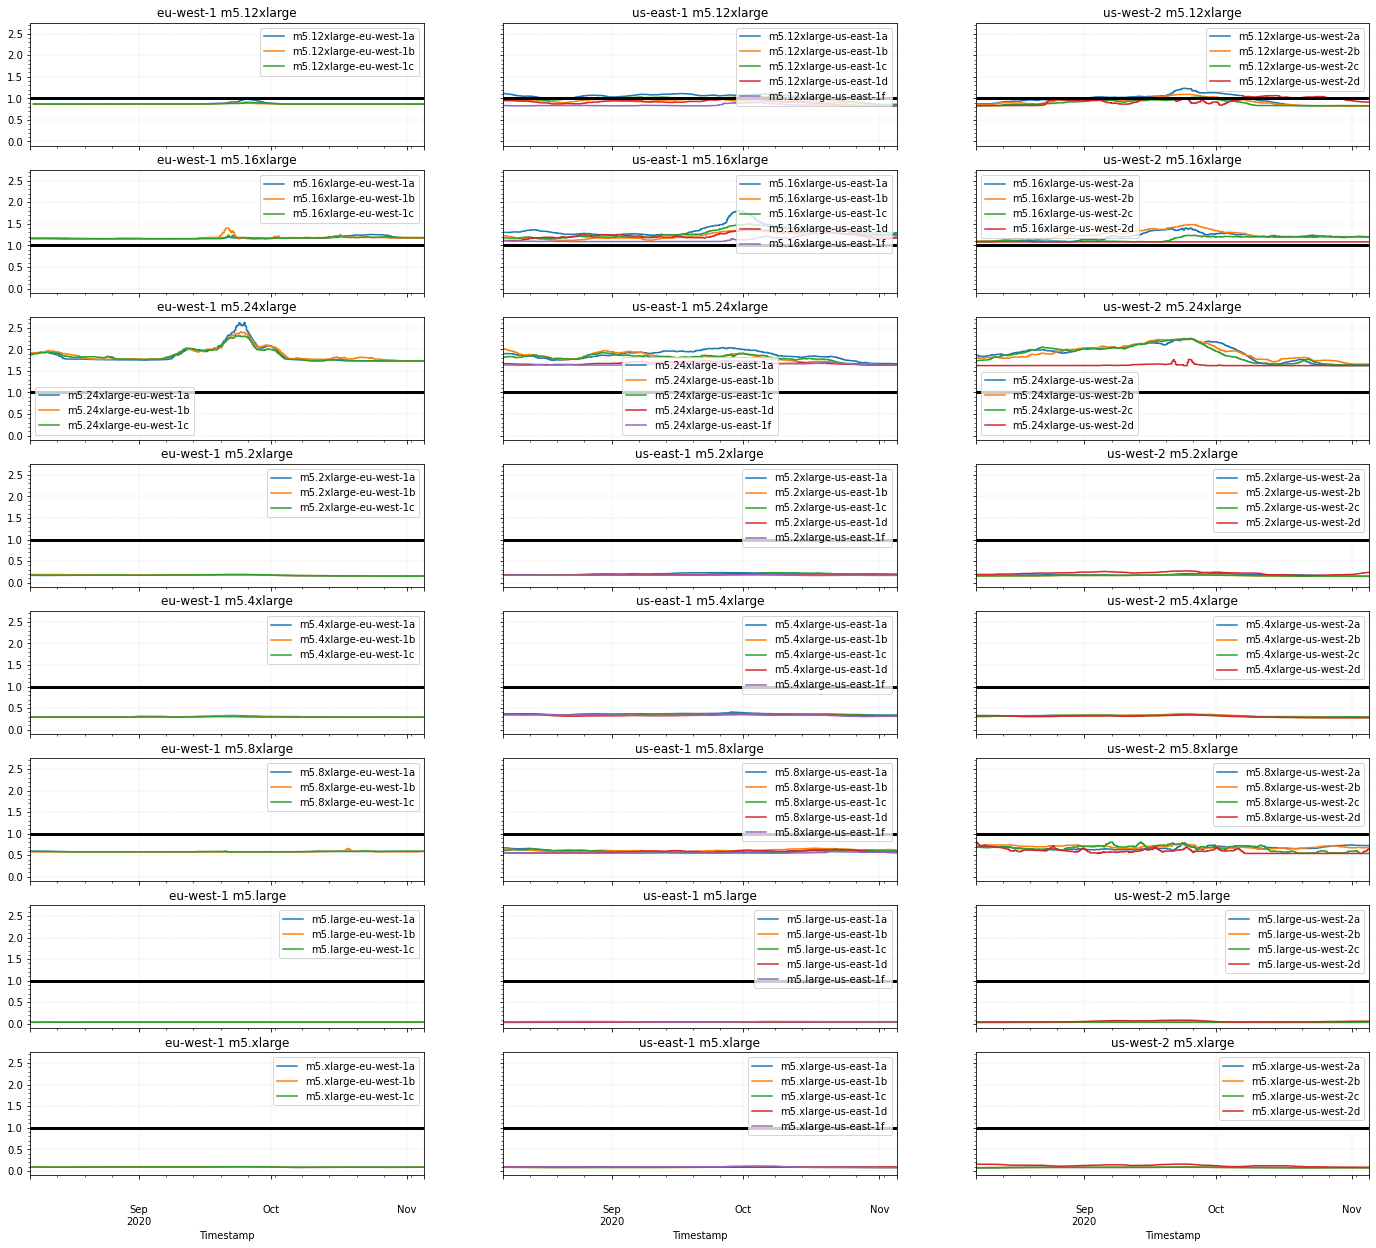

In [27]:
plot_spot_prices_grid(cap_price_w.value, spot_prices_dict,instances_w,regions_w)

## Plotting Spot price - by Region
Now let's Iterates over every region and groups all the instance types within the same region.

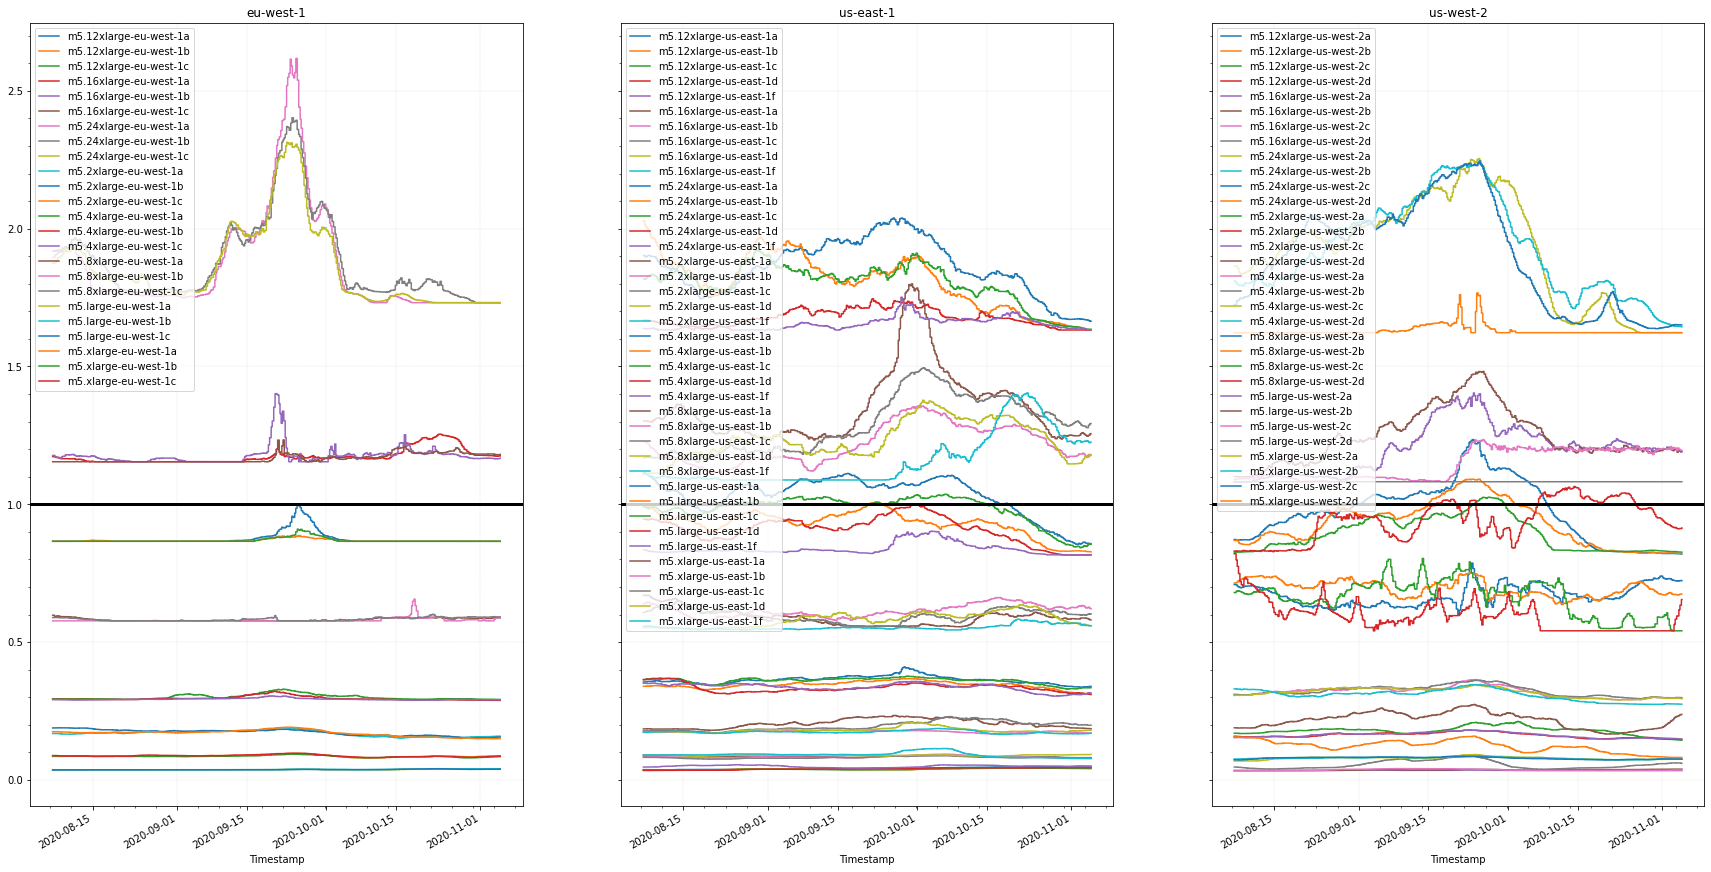

In [29]:
plot_spot_aggregated_by_region(cap_price_w.value,spot_prices_dict,instances_w,regions_w, legend=True)

## Storing the info into xlsx files

Finally, if you are interested on dumping all the inputs in an excel spreadsheet or similar, the following section will create a excel file for each region with tabs for each instance tab selected. You will be able to download it from jupyter. The files have been created on the same directory you are running the current notebook.

In [30]:
for region, region_dict in tqdm_notebook(spot_prices_dict.items()):
    excel_writer = pd.ExcelWriter("spot_prices-region-{}.xlsx".format(region), engine='xlsxwriter')
    for instance_type, spot_prices_pd in tqdm_notebook(region_dict.items()):
        spot_prices_pd.to_excel(excel_writer, sheet_name="{}".format(instance_type))
    excel_writer.save()